In [18]:
import pandas 
import numpy 
import matplotlib.pyplot 
import torch
from src import TunableAttentionRegression, tokenize
from searchGrid import *

In [23]:
#training data/ validation data
trainingDatasets, validationDatasets, testingDatasets = get_datasets_all()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the model
model = TunableAttentionRegression(hidden_size=64, numberOfHeads=16).to(device)
# Create the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Create the loss function
criterion = torch.nn.L1Loss().to(device)

# Create the training data loader
trainingDataLoader = torch.utils.data.DataLoader(trainingDatasets,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

validationDataLoader = torch.utils.data.DataLoader(validationDatasets,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

testinDataLoader = torch.utils.data.DataLoader(testingDatasets,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sequence = str(row[0])
c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preTokens.append((sequence, row[2]))
c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preTokens.

In [25]:
# Train the model
for epoch in range(11):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_steps = 0
    for i, data in enumerate(trainingDataLoader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device)).squeeze()[:, 0].to(device)
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_steps += 1
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                            running_loss / epoch_steps))
            running_loss = 0.0

    # Validation loss
    val_loss = 0.0
    val_steps = 0
    total = 0
    correct = 0
    for i, data in enumerate(validationDataLoader):
        with torch.no_grad():
            inputs, labels = data

            outputs = model(inputs.to(device)).squeeze()[:, 0].to(device)
            total += labels.size(0)
            correct += (outputs.to(device) == labels.to(device)).sum().item()

            loss = criterion(outputs.to(device), labels.to(device))
            val_loss += loss.cpu().numpy()
            val_steps += 1
    
    #save the model from this epoch
    torch.save(model.state_dict(), "secondTry_model_hs_32_epoch_{}.pt".format(epoch))

[1,  2000] loss: 0.051
[1,  4000] loss: 0.025
[1,  6000] loss: 0.016
[1,  8000] loss: 0.012
[1, 10000] loss: 0.009
[1, 12000] loss: 0.008
[1, 14000] loss: 0.006
[2,  2000] loss: 0.044
[2,  4000] loss: 0.022
[2,  6000] loss: 0.014
[2,  8000] loss: 0.011
[2, 10000] loss: 0.009
[2, 12000] loss: 0.007
[2, 14000] loss: 0.006


In [36]:
#Test model and get accuracy
test_loss = 0.0
test_steps = 0
total = 0
correct = 0
model.to('cpu')
model.eval()
preds = []

# Test model and calculate accuracy
for i, data in enumerate(testinDataLoader):
    with torch.no_grad():
        inputs, labels = data

        outputs = model(inputs).squeeze()[:, 0]
        predicted = outputs
        preds.append((labels, predicted))

In [39]:
allPredictions = []
allLabels = []
for label, pred in preds:
    allPredictions.append(pred)
    allLabels.append(label)

In [46]:
flatPreds = torch.stack(allPredictions).flatten().tolist()
flatLabels = torch.stack(allLabels).flatten().tolist()

In [48]:
import matplotlib.pyplot 

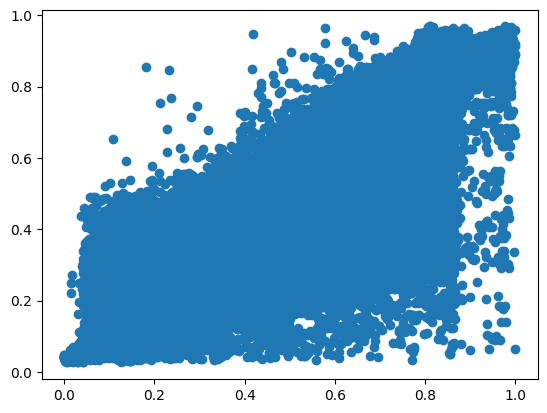

In [49]:
matplotlib.pyplot.scatter(flatLabels, flatPreds)
matplotlib.pyplot.xlabel("True")
matplotlib.pyplot.ylabel("Predicted")
matplotlib.pyplot.show()